# Time tracking

- 11/19, 5:30 - 6:00, initial setup, starting scratchwork
- 11/20, 4:45 - 5:30, onto GitHub, got Sinkhorn to run
- 11/21, 3:00 - 4:30, improved Sinkhorn, ran it on MNIST
- 11/22, 5:20 - 7:05, implemented gradients for regularized Sinkhorn
- 11/25, 4:50 - 

In [1]:
# Autoreload so we don't have to reimport packages when we change them
%load_ext autoreload
%autoreload 2

In [2]:
## Imports

# Basic
import numpy as np
import matplotlib.pyplot as plt
import random

# My code
import bary

# Data: https://www.tensorflow.org/datasets
import tensorflow_datasets as tfds

# Implementing Sinkhorn

### Basic run

First get it to run on 1D data, and using the differentiability to gradient descent to a fixed measure

In [234]:
# Number of points in 1D
n = 10

# Locations I'll use
x = list(range(n))

# Target measure
## p even though it's not a probability distribution
p = [random.random() for i in range(n)]
p = p / np.sum(p)

# Distance matrix
M = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        M[i,j] = abs(i-j)

In [235]:
l = 10
q = np.zeros(n)
q[0] = sum(p)

bary.sinkhorn(p,q,M,l,50)

array([4.16324842])

In [236]:
# Test
p = np.ones(10) * 0.01
q = np.zeros(10)
p[0] = p[0] + 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = p[3] + 0.4
bary.sinkhorn(p,q,M,50)

array([1.28589744])

In [237]:
# Approx ish
# So it passes
0.3 + 2*0.2 + 0.4 + 0.01 * (1 + 0 + 0 + 1 + 2 + 3 + 4 + 5 + 6 + 7)

1.3900000000000001

In [238]:
# Test
p = np.ones(10) * 0.01
q = np.zeros(10)
p[0] = p[0] + 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = p[4] + 0.4
p = p * 5
q = q * 5
bary.sinkhorn(p,q,M,30)

array([6.42950814])

Ok, looks like the Sinkhorn code is correct. To do though:
- Edit so r = 0 doesn't throw errors
- Run it on some Google Quick Draw! stuff
- Vectorize better for computing distance of one histogram to many

### Refining it

- $r = 0$ doesn't throw errors
- Iteration can be controlled or is set automatically
- More vectorized

In [239]:
# Test
p = np.zeros(10)
q = np.zeros(10)
p[0] = 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = 0.5
bary.sinkhorn(p,q,M,10,20)

array([1.19994503])

In [240]:
# Wasserstein distance
0.3 * 1 + 0.2 * 2 + 0.5 * 1

1.2

So the $r=0$ and variable number of iterations went through without and issue

Now to vectorize better...

In [247]:
A = np.zeros((3,4))
np.shape(A)

(3, 4)

In [248]:
np.shape(A)[1]

4

In [249]:
# Test
p = np.zeros(10)
q = np.zeros(10)
p[0] = 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = 0.5

In [250]:
Q = np.transpose(np.array([q,q,q,q]))
np.shape(Q)

(10, 4)

In [251]:
bary.sinkhorn(p,Q,M,10,20)

array([1.19994503, 1.19994503, 1.19994503, 1.19994503])

Looks like that's working!

In [252]:
# And scaling things gives expected results
bary.sinkhorn(4*p,4*Q,M,10,20)

array([4.79978012, 4.79978012, 4.79978012, 4.79978012])

## Testing on MNIST

Using TensorFlow for easy data management: https://www.tensorflow.org/datasets/catalog/mnist

In [4]:
# Following this example: https://www.tensorflow.org/datasets/overview

ds = tfds.load('mnist', split='train')

In [5]:
# The size of the images
for ex in ds.take(1):
    print(np.shape(ex['image']))

(28, 28, 1)


In [6]:
## Convert to a numpy array of histograms

# Size of histograms
n = 28 * 28

# Number of images to convert
N = 100

# Allocate memory
X = np.zeros((n,N))
y = np.zeros(N)

# Iterate to populate X
i = 0
for ex in ds.take(N):
    # Make sure to normalize too!
    aux = np.ravel(ex['image'].numpy())
    X[:,i] = aux / sum(aux)
    y[i]   = ex['label'].numpy()
    i = i + 1

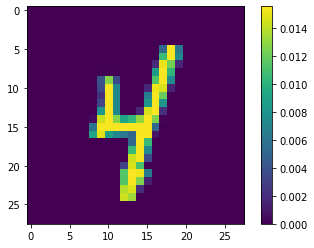

In [7]:
# A quick check that we can recover the original images
img = np.reshape(X[:,0], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [8]:
# Sort things in terms of the labels
sort = np.argsort(y)
y = y[sort]
X = X[:,sort]

In [9]:
# Get M

# To make sure I don't mess up indexing things, I'll set up a list of locations and reshape it into a matrix
# So when I calculate a pairwise distance in the matrix, I can easily associate it to the location in the vector
locations_vec = np.array(range(n))
locations_arr = np.reshape(locations_vec, (28,28))

M = np.zeros((n,n))
# Having 4 "for" loops is a bit embarassing, but I'm not trying to think too hard right now
for i1 in range(28):
    for j1 in range(28):
        for i2 in range(28):
            for j2 in range(28):
                M[locations_arr[i1,j1], locations_arr[i2,j2]] = np.sqrt((i1-i2)**2 + (j1-j2)**2)

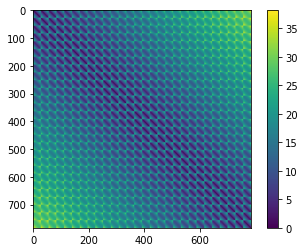

In [10]:
# The plot looks reasonable
plt.imshow(M)
plt.colorbar()
plt.show()

In [11]:
# Compute pairwise sinkhorn divergences

# Using settings from the original Marco Cuturi Sinkhorn paper
l = 9
iterations = 20

K = np.exp(-l * M)

D = np.zeros((N,N))

for i in range(N):
    # Compute the distance from image i to the rest of them
    D[i,:] = bary.sinkhorn_mk(X[:,i],X,M,K,iterations)

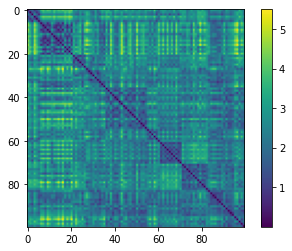

In [12]:
# Plot them
plt.imshow(D)
plt.colorbar()
plt.show()

In [13]:
# Compare to when the digits are equal
B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = (y[i] == y[j])

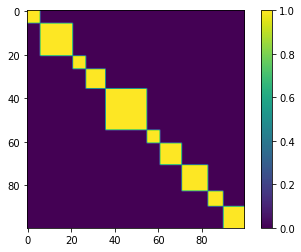

In [312]:
plt.imshow(B)
plt.colorbar()
plt.show()

That looks awesome!

# Differentiability

- Implement the code to calculate gradients of Sinkhorn (maybe start with regularized)
- Test on MNIST data
 - Gradient descent from uniform distribution to a given digit
 - Find an average case digit
- Test on Quick Draw!: https://www.tensorflow.org/datasets/catalog/quickdraw_bitmap

From the "Differential Properties of Sinkhorn" paper, the gradient in the first histogram is given by an optimal dual variable

Comparing the formula in that paper to the formula in the original Sinkhorn paper, it seems we can back this $\alpha_*$ out of the results of the Sinkhorn iteration

So, run the code above to get an MNIST digit

## Regularized

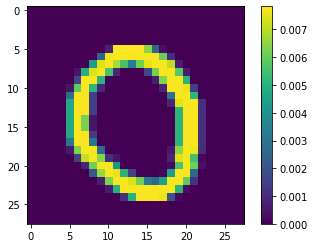

In [71]:
c = X[:,0]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

Now I'll do some gradient descent to find that digit

In [40]:
steps = 100
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    alpha = bary.Dsinkhorn_reg(r,c,M,l,K,iterations)
    # Reformat to match shape of r and move opposite that direction
    r = r - eta * np.reshape(alpha,np.shape(r))
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

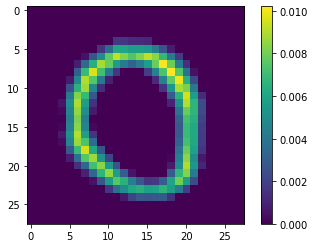

In [43]:
i = 2
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

It works! But for some reason I have to dampen it a whole lot. It seems the gradient is typically orders of magnitude too large?

FIXME: think more about this issue. I'll ignore it for now.

Ok, later I thought about it and figured out $\alpha_*$ was wrong and fixed that. Now the only remaining issue is with the support, that once a pixel is set to zero it's gone for good and we never color it again. Maybe the way to fix this is to use another algorithm, or add a bit of noise at each step.

Now let's try getting an average case digit:
- Run the digit sorting code above
- Pick out some 7s
- Do the thing

In [44]:
C = X[:,71:83]

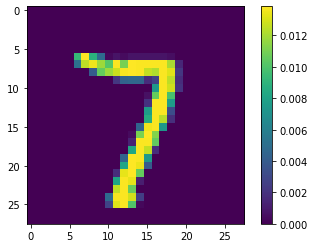

In [45]:
c = C[:,0]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

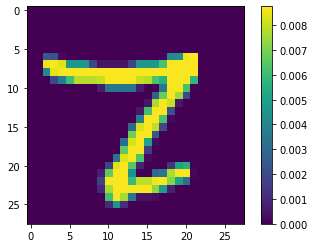

In [46]:
c = C[:,-1]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [47]:
np.shape(C)

(784, 12)

In [63]:
steps = 100
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    alpha = bary.Dsinkhorn_reg(r,C,M,l,K,iterations)
    # Average the gradients and modify r
    r = r - eta * (alpha @ np.ones(12)) / 12
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

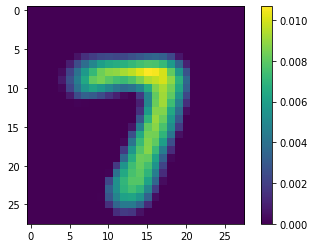

In [65]:
i = 2
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

Again, after the edit I don't have to use eta, but I run into the support issue.

This is really cool. Hopefully I'm overlooking something and I can get rid of the eta. Either way, I can change eta over time (i.e. increase it after 10 gradient steps). Let's try that:

In [364]:
# Input: current r, C for the target histograms, eta to use, number of steps to do, and M,l,iterations
# Output: R, the steps
def descend(r,C,steps,eta,M,l,iterations=20):
    
    # Set up thingies
    k = np.shape(C)[1]
    K = np.exp(-l*M)
    
    # Iterate
    for i in range(steps):
        # Gradient
        alpha = bary.Dsinkhorn_reg(r,C,M,l,K,iterations)
        # Average the gradients and modify r
        r = r - eta * (alpha @ np.ones(k)) / k
        # Keep it nonnegative and unit mass
        r = r * (r>0)
        r = r / sum(r)
    
    # Return
    return r

In [370]:
np.shape(r)

(784,)

In [371]:
n = 28*28
r = np.ones(n) / n

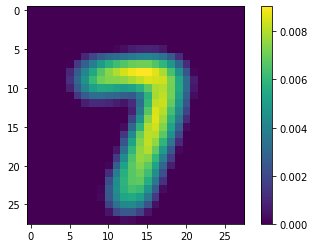

In [373]:
## Version 1

n = 28*28
r = np.ones(n) / n

# Descend
steps = 20
eta = 0.0001
r = descend(r,C,steps,eta,M,l)

# Plot
img = np.reshape(r, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

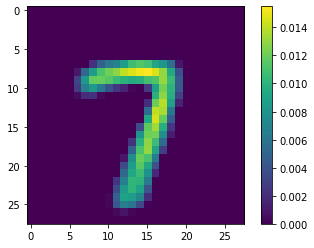

In [374]:
## Version 2

n = 28*28
r = np.ones(n) / n

# Descend
steps = 10
eta = 0.0001
r = descend(r,C,steps,eta,M,l)
steps = 10
eta = 0.001
r = descend(r,C,steps,eta,M,l)

# Plot
img = np.reshape(r, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

So yes, increasing eta at the right time can speed up convergence :)

## Sharp

Now compute gradients with the sharp Sinkhorn

First I'll try coding up the stuff from the Diffy Sink paper in **bary.py**.

Notes:
- The p. 23 formula takes some parsing to realize we're solving a system $K f = g$ for $f$
- To figure out $g$ and $K$, we need
 - $T$, $\overline{T}$
 - $L$

**Ok** important thing: I realized I basically just guessed at how to get $\alpha_*$ from $u$ by looking at the formulas and pattern matching, but the way I did it leaves an extra degree of freedom, so it doesn't actually find $\alpha_*$. Looking at the Fast Barycenter paper, p. 6 gives the right way to get $\alpha_*$ from $u$, which is to ensure its sum is zero.

I fixed that and the previous results look better, but now the FIXME issue is that once a pixel value is set to zero it never comes back, which isn't great. Idk how to fix that.

Ok let's see if the code works. Run the above stuff to load the MNIST things, then for a single digit...

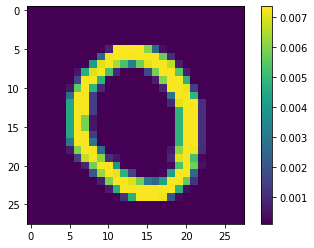

In [90]:
# Add a bit of "noise"
c = X[:,0]
c = c + 0.0001 * np.ones(28*28)
c = c / sum(c)
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [98]:
steps = 10
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    gradient = bary.Dsinkhorn(r,c,M,l,K,iterations)
    # Reformat to match shape of r and move opposite that direction
    r = r - eta * np.reshape(gradient,np.shape(r))
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

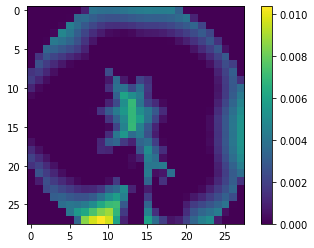

In [102]:
i = 1
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

Ok, a lot of entries of $c$ are zero which is an issue. I added some "noise" to avoid that. But still the gradient seems to be wrong. Need to go back and check the code for Dsinkhorn.

# Clustering

Try to do k-means ish stuff. Ex. "discover" that there are 2 clusters of sevens: with and without the middle line.